<a href="https://colab.research.google.com/github/soyoung96/deep-classifier-resnet50/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [ ]:
path2data = 'data'


train_ds = datasets.STL10(path2data,split='train',download =True,
                         transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data,split='test',download =True,
                         transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))



Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [ ]:
train_ds[0]

(tensor([[[0.5725, 0.5725, 0.5725,  ..., 0.6353, 0.6353, 0.6353],
          [0.5725, 0.5725, 0.5725,  ..., 0.6392, 0.6392, 0.6392],
          [0.5725, 0.5725, 0.5725,  ..., 0.6431, 0.6431, 0.6431],
          ...,
          [0.5098, 0.5176, 0.4588,  ..., 0.5373, 0.5882, 0.5529],
          [0.5255, 0.6078, 0.3451,  ..., 0.5294, 0.5333, 0.5373],
          [0.5294, 0.3804, 0.4549,  ..., 0.5412, 0.5765, 0.5412]],
 
         [[0.5608, 0.5608, 0.5608,  ..., 0.6235, 0.6235, 0.6235],
          [0.5608, 0.5608, 0.5608,  ..., 0.6196, 0.6196, 0.6196],
          [0.5608, 0.5608, 0.5608,  ..., 0.6196, 0.6196, 0.6196],
          ...,
          [0.4471, 0.4667, 0.4078,  ..., 0.5176, 0.5412, 0.4784],
          [0.4627, 0.5529, 0.2902,  ..., 0.5137, 0.4863, 0.4706],
          [0.4667, 0.3255, 0.4078,  ..., 0.4980, 0.5333, 0.5020]],
 
         [[0.4314, 0.4314, 0.4314,  ..., 0.4941, 0.4941, 0.4941],
          [0.4314, 0.4314, 0.4314,  ..., 0.4941, 0.4941, 0.4941],
          [0.4314, 0.4314, 0.4314,  ...,

In [ ]:
#RGB mean,std of train set
train_meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds] # RGBmean list by sample
train_stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds] # RGBstd list by sample
'''
about axis =>
http://taewan.kim/post/numpy_sum_axis/

'''


'''
train_meanRGB=[array([0.5199615 , 0.47785485, 0.34138668], dtype=float32),
 array([0.54801244, 0.49918514, 0.3546922 ], dtype=float32),
 array([0.35330972, 0.476511  , 0.32713312], dtype=float32),
 array([0.28504393, 0.18103725, 0.06127664], dtype=float32),...]

'''
train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


#RGB mean,std of validation set
val_meanRGB = [np.std(x.numpy(),axis=(1,2)) for x,_ in val_ds]
val_stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in val_ds]

val_meanR = np.mean([m[0] for m in train_meanRGB])
val_meanG = np.mean([m[1] for m in train_meanRGB])
val_meanB = np.mean([m[2] for m in train_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR,train_meanG,train_meanB)
print(val_meanR,val_meanG,val_meanB)




0.4467106 0.43980986 0.40664646
0.4467106 0.43980986 0.40664646


In [ ]:
#set transforms
train_transformation = transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Resize(224),
                                           transforms.Normalize([train_meanR,train_meanG,
                                                                train_meanB],
                                                               [train_stdR,train_stdG,
                                                                train_stdB]),
                                           transforms.RandomHorizontalFlip()])

val_transformation = transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Resize(224),
                                           transforms.Normalize([val_meanR,val_meanG,
                                                                val_meanB],
                                                               [val_stdR,val_stdG,
                                                                val_stdB]),
                                           ])

In [ ]:
# apply transforamtion
train_ds.transform = train_transformation
val_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds,batch_size = 32,shuffle=True)
val_dl = DataLoader(val_ds,batch_size = 32,shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices:  [ 235 3980  905 2763]


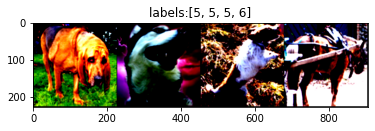

In [ ]:
#display img data
def show(img,y= None,color= True):
  npimg= img.numpy()
  npimg_tr = np.transpose(npimg,(1,2,0)) #regular form (1,2,0)
  plt.imshow(npimg_tr)

  if y is not None:
    plt.title('labels:' + str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size =4
rnd_inds =np.random.randint(0,len(train_ds),grid_size)
print('image indices: ',rnd_inds)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid,nrow=grid_size,padding =2)

show(x_grid,y_grid)

In [ ]:
class BasicBlock(nn.Module):
  expansion =1 #class variable
  def __init__(self,in_channels,out_channels,stride =1):
    super().__init__()

    self.residual_function=nn.Sequential(
        nn.Conv2d(in_channnels,out_channels,kernel_size = 3,
                  stride =stride,padding =1 ,bias=False), #bias=Flase because of BN
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels * BasicBlock.expansion,kernel_size =3,stride = 1,
                  padding =1,bias = False),
        nn.BatchNorm2d(out_channels * BasicBlock.expansion)
    )
    # case of input ch == out ch and input feature map size == output feature map size
    self.shortcut = nn.Seqential() # nothing
    self.relu = nn.ReLU()

    # case of input ch != out ch
    if stride != 1 or in_channels != out_channels * BasicBlock.expansion :
      self.shortchut = nn.Sequential(nn.Conv2d(in_channels,out_channels * BasicBlock.expansion,
                                               kernel_size =1,stride =stride,bias=False),
                                     nn.BatchNorm2d(out_channels * BasicBlock.expansion))
      
  def forward(self,x):
    x= self.residual_function(x) + self.shortcut(x)
    x = self.relu(x) #not pre activation
    return x


In [ ]:
class BottleNeck(nn.Module):
  expansion =4
  def __init__(self,in_channels,out_channels,stride =1):
    super().__init__()

    self.residual_function=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size = 1,
                  stride =1 ,bias=False), #bias=Flase because of BN
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size =3,stride = stride,
                  padding =1,bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels*BottleNeck.expansion,kernel_size=1,
                  stride = 1,bias = False),
        nn.BatchNorm2d(out_channels*BottleNeck.expansion)
    )
    # case of input ch == out ch and input feature map size == output feature map size
    self.shortcut = nn.Sequential() # nothing
    self.relu = nn.ReLU()

    # case of input ch != out ch
    if stride != 1 or in_channels != out_channels * BottleNeck.expansion :
      self.shortcut = nn.Sequential(nn.Conv2d(in_channels,out_channels * BottleNeck.expansion,
                                               kernel_size =1,stride =stride,bias=False),
                                     nn.BatchNorm2d(out_channels * BottleNeck.expansion))
      
  def forward(self,x):
    x= self.residual_function(x) + self.shortcut(x)
    x = self.relu(x) #not pre activation
    return x

In [ ]:
class ResNet(nn.Module):
  def __init__(self,block,num_block,num_classes = 10,
               init_weights=True):
    super().__init__()

    self.in_channels = 64

    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=7,stride =2,padding=3,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )


    # at every conv_x, only 1st elt layer has 2 stride s.t stride
    # reduce feature map size ,the other has 1 stride 
    self.conv2_x=self._make_layer(block,64,num_block[0],1)
    self.conv3_x = self._make_layer(block,128,num_block[1],2)
    self.conv4_x = self._make_layer(block,256,num_block[2],2)
    self.conv5_x = self._make_layer(block,512,num_block[3],2)

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))

    self.fc = nn.Linear(512* block.expansion,num_classes)
    
    # weights inittialization
    if init_weights:
      self._initialize_weights()


  def _make_layer(self,block,out_channels,num_blocks,stride):
    strides = [stride] + [1] * (num_blocks -1)
    layers = []
    for stride in strides:
      # out_channels == 1st elt layer's out_channels
      layers.append(block(self.in_channels,out_channels,stride))
      self.in_channels = out_channels * block.expansion

    return nn.Sequential(*layers)

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2_x(x)
    x = self.conv3_x(x)
    x = self.conv4_x(x)
    x = self.conv5_x(x)

    x = self.avg_pool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc(x)

    return x

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

    


In [ ]:
def resnet18():
  return ResNet(BasicBlock,[2,2,2,2])

def resnet34():
  return ResNet(BasicBlock,[3,4,6,3])

def resnet50():
  return ResNet(BottleNeck,[3,4,6,3])

def resnet101():
  return ResNet(BottleNeck,[3,4,23,3])

def resnet152():
  return ResNet(BottleNeck,[3,8,36,3])
 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model = resnet50().to(device)

In [ ]:
loss_ftn = nn.CrossEntropyLoss(reduction = "sum")
opt = optim.Adam(model.parameters(),lr=0.001)

# https://deep-deep-deep.tistory.com/56
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt,mode = 'min',factor =0.1,patience=10)

In [ ]:
# function to get current lr
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [ ]:
#corrects per mini batch
def metric_batch(output,target):
  pred = output.argmax(1,keepdim =True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects


#loss,corrects per mini batch
def loss_batch(loss_ftn,output,target,opt=None):
  loss = loss_ftn(output,target)
  metric_b = metric_batch(output,target)

  if opt is not None: # train # if opt not,then test of valildation set
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(),metric_b

In [ ]:
def loss_epoch(model,loss_ftn,dataset_dl,sanity_check = False,opt=None):
  running_loss = 0.
  running_metric=0.
  len_data = len(dataset_dl.dataset)

  for xb,yb in dataset_dl:
    xb=xb.to(device)
    yb = yb.to(device)
    output = model(xb)

    loss_b,metric_b = loss_batch(loss_ftn,output,yb,opt)
    running_loss += loss_b

    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True:
      break
    
  loss = running_loss/len_data
  metric = running_metric/len_data

  return loss,metric



In [ ]:
def train_val(model,params):
  num_epochs = params["num_epochs"]
  loss_ftn = params['loss_ftn']
  opt = params["optimizer"]
  train_dl =params["train_dl"]
  val_dl = params["val_dl"]
  sanity_check = params["sanity_check"]
  lr_scheduler = params["lr_scheduler"]

  loss_history = {"train":[], "val":[]}
  metric_history={"train":[],"val":[]}

  best_loss = float('inf')



  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{} current lr={}'.format(epoch+1,num_epochs,current_lr))

    model.train()

    #train per epoch
    train_loss,train_metric = loss_epoch(model,loss_ftn,train_dl,sanity_check,opt)
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # eval per epoch
    model.eval()
    with torch.no_grad():
      val_loss,val_metric = loss_epoch(model,loss_ftn,val_dl,sanity_check)
      loss_history['val'].append(val_loss)
      metric_history['val'].append(val_metric)

    if val_loss < best_loss:
      best_loss = val_loss
      print('Get best val_loss')

    lr_scheduler.step(val_loss)

    print('train loss: {:.6f}, val loss: {:.6f}, accuracy: {:.2f}'.format(
        train_loss,val_loss,100*val_metric
    ))

  
  
  return model,loss_history,metric_history



In [ ]:
params_train={
    'num_epochs':20,
    'optimizer':opt,
    'loss_ftn':loss_ftn,
    'train_dl':train_dl,
    "val_dl":val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
  

}


In [ ]:
model,loss_hist,metric_hist = train_val(model,params_train)

Epoch 1/20 current lr=0.001
Get best val_loss
train loss: 1.977581, val loss: 37.098612, accuracy: 20.24
Epoch 2/20 current lr=0.001
Get best val_loss
train loss: 1.757167, val loss: 1.729488, accuracy: 32.52
Epoch 3/20 current lr=0.001
Get best val_loss
train loss: 1.618480, val loss: 1.567189, accuracy: 39.84
Epoch 4/20 current lr=0.001
Get best val_loss
train loss: 1.512958, val loss: 1.449543, accuracy: 43.29
Epoch 5/20 current lr=0.001
train loss: 1.412606, val loss: 1.526809, accuracy: 45.11
Epoch 6/20 current lr=0.001
train loss: 1.335742, val loss: 1.770467, accuracy: 37.57
Epoch 7/20 current lr=0.001
Get best val_loss
train loss: 1.236190, val loss: 1.440186, accuracy: 47.66
Epoch 8/20 current lr=0.001
Get best val_loss
train loss: 1.183230, val loss: 1.404960, accuracy: 49.46
Epoch 9/20 current lr=0.001
Get best val_loss
train loss: 1.138552, val loss: 1.382525, accuracy: 50.32
Epoch 10/20 current lr=0.001
train loss: 1.042667, val loss: 1.426003, accuracy: 53.73
Epoch 11/20 